# Data Science Lab Project, Course 67818
## Adam Shtrasner
## Asif Kagan
## Peleg Reichman

# Initial Preprocess

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import isnan
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**`Instruction`: Change path in file_name to insert your own data**

In [5]:
file_name = '/content/drive/MyDrive/DataScienceProject/train_data.csv' 

In [6]:
df = pd.read_csv(file_name)

As a first step, we want to get to know and study the large dataset that we have, understand which features are more important, which are less, where there are junk values ​​such as null values, values ​​that do not make sense in relation to what they are supposed to represent, check correlation between the features and read about them.

First, let's take a look at the data:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626822 entries, 0 to 626821
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  626822 non-null  int64  
 1   OBJECTID                    626822 non-null  int64  
 2   FOD_ID                      626822 non-null  int64  
 3   FPA_ID                      626822 non-null  object 
 4   SOURCE_SYSTEM_TYPE          626822 non-null  object 
 5   SOURCE_SYSTEM               626822 non-null  object 
 6   NWCG_REPORTING_AGENCY       626822 non-null  object 
 7   NWCG_REPORTING_UNIT_ID      626822 non-null  object 
 8   NWCG_REPORTING_UNIT_NAME    626822 non-null  object 
 9   SOURCE_REPORTING_UNIT       626822 non-null  object 
 10  SOURCE_REPORTING_UNIT_NAME  626822 non-null  object 
 11  LOCAL_FIRE_REPORT_ID        140480 non-null  object 
 12  LOCAL_INCIDENT_ID           353364 non-null  object 
 13  FIRE_CODE     

Summerize null values count, for each feature:

In [ ]:
df.isna().sum()

Unnamed: 0                         0
OBJECTID                           0
FOD_ID                             0
FPA_ID                             0
SOURCE_SYSTEM_TYPE                 0
SOURCE_SYSTEM                      0
NWCG_REPORTING_AGENCY              0
NWCG_REPORTING_UNIT_ID             0
NWCG_REPORTING_UNIT_NAME           0
SOURCE_REPORTING_UNIT              0
SOURCE_REPORTING_UNIT_NAME         0
LOCAL_FIRE_REPORT_ID          486342
LOCAL_INCIDENT_ID             273458
FIRE_CODE                     518340
FIRE_NAME                     320037
ICS_209_INCIDENT_NUMBER       618192
ICS_209_NAME                  618192
MTBS_ID                       623132
MTBS_FIRE_NAME                623132
COMPLEX_NAME                  625075
FIRE_YEAR                          0
DISCOVERY_DATE                     0
DISCOVERY_DOY                      0
DISCOVERY_TIME                294076
STAT_CAUSE_CODE                    0
STAT_CAUSE_DESCR                   0
CONT_DATE                     297088
C

We can see that the following features have a significant high amount of null values:

*   FIRE_CODE
*   ICS_209_INCIDENT_NUMBER
*   ICS_209_NAME
*   MTBS_ID
*   MTBS_FIRE_NAME
*   COMPLEX_NAME

With all of them having more than 500k null values, while the whole data is comprised of 626822 rows. Therefore, we'll consider just dropping them.

We can see that there are some features with alot of null values - we'll investigate them and see how to impute them.

# Visualization

### General distribution of fire causes across all dataset 

Text(0.5, 1.0, 'General distribution of fire causes across all dataset')

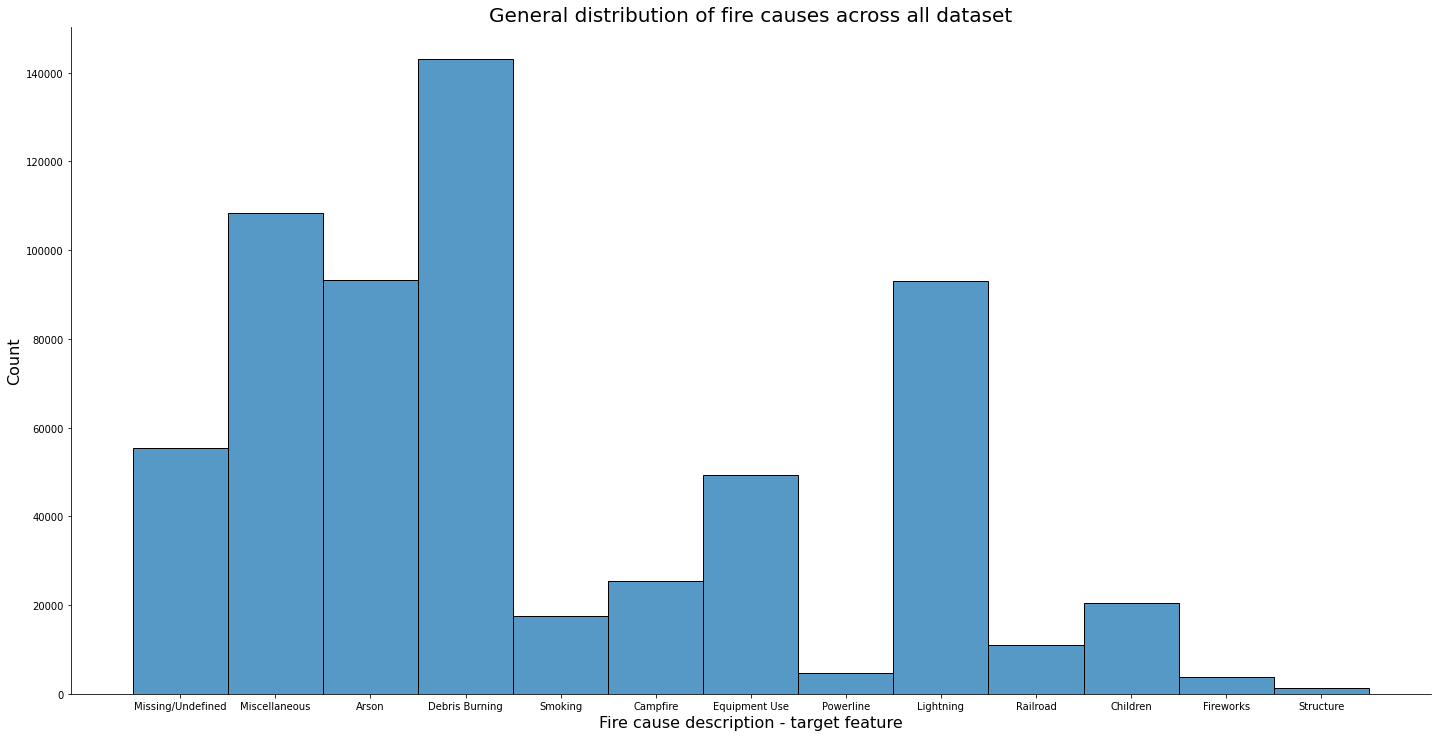

In [ ]:
fig = sns.displot(df, x="STAT_CAUSE_DESCR", height=10, aspect=2)
plt.xlabel("Fire cause description - target feature", fontsize=16);
plt.ylabel("Count", fontsize=16);
plt.title("General distribution of fire causes across all dataset", fontsize=20)

In [ ]:
df["STAT_CAUSE_DESCR"].value_counts()

Debris Burning       143074
Miscellaneous        108372
Arson                 93304
Lightning             93057
Missing/Undefined     55397
Equipment Use         49423
Campfire              25367
Children              20354
Smoking               17571
Railroad              11053
Powerline              4733
Fireworks              3865
Structure              1252
Name: STAT_CAUSE_DESCR, dtype: int64

## Trends in Fire Incidents per Week of the Year According to Fire Cause

Let's see if we can find a certain trend when it comes to the cause of the fire over the weeks of each year. 

In [ ]:
df_copy = df.copy(deep=True)

# Create column for discovery week
df_copy['DISCOVERY_WOY'] = df_copy['DISCOVERY_DOY'] // 7

In [ ]:
df_copy = df_copy.astype({'FIRE_YEAR':'string', 'DISCOVERY_WOY':'string'})
df_copy["YEAR_AND_WEEK"] = df_copy["FIRE_YEAR"] + '/' + df_copy['DISCOVERY_WOY']

In [ ]:
def plot_cause_of_fire_over_weeks(df, cause_of_fire):
  new_df = df.loc[df['STAT_CAUSE_DESCR'] == cause_of_fire]
  new_df = new_df.groupby(["YEAR_AND_WEEK"]).size().reset_index(name='counts')
  fig = px.line(new_df, x="YEAR_AND_WEEK", y="counts", title=f'Cause of Fire: {cause_of_fire}')
  fig.show()

In [ ]:
causes_of_fire = df_copy['STAT_CAUSE_DESCR'].unique()

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[0])

We can see that between the years 1996 and 2002 there has been a large decrease in fire incidents where the cause is unknown.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[1])

There seems to be an increase in fire incidents between the years 2005 to 2008.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[2])

There is a decrease in fire incidents from 2010 where the fire cause is arson.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[3])

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[4])

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[5])

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[6])

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[7])

We can deffinately see an increase in fires caused by powerline from 2009.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[8])

More lightning happen during the winter, therefore we see bigger amount of fires caused by lightning during the beginning and the end of a year.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[9])

As opposed to the trend in fires caused by powerline, here we see a decrease in fires from around 2006 when it comes to fires caused by railroads.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[10])

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[11])

We can see that in weeks at the start of July, there is a sharp increase in fire incidents caused by fireworks, which makes sence since there are alot of fireworks during the 4th of July.

In [ ]:
plot_cause_of_fire_over_weeks(df_copy, causes_of_fire[12])

## Number of Fire Incidents per State

In [13]:
def plot_distribution(df):
  # drop null values
  df = df.dropna()

  plt.figure(figsize=(18, 10))
  plt.xticks(rotation = 90)
  sns.countplot(df, order = df.value_counts().index)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


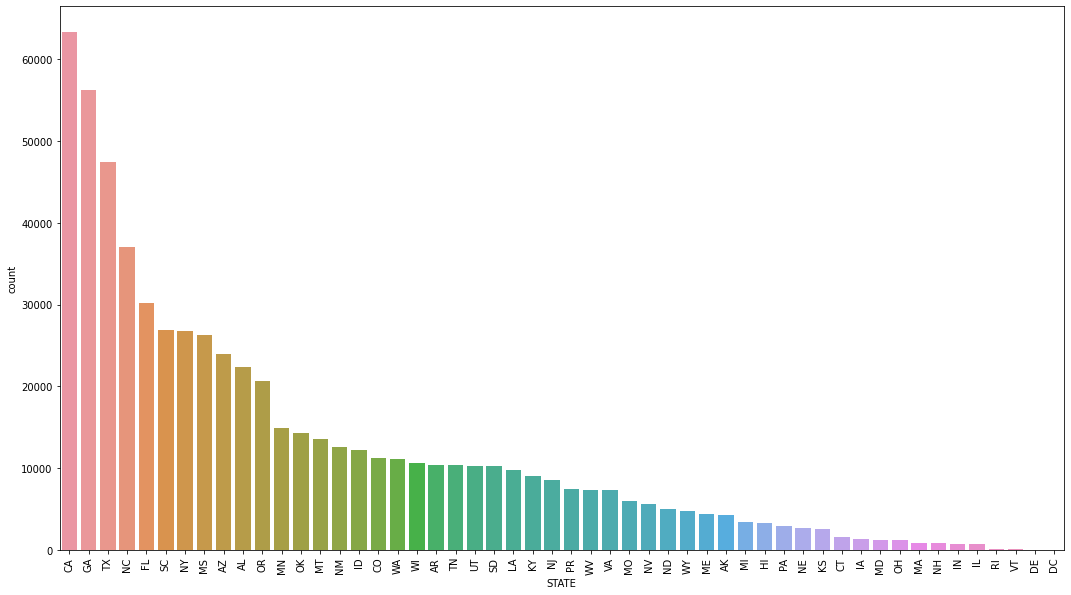

In [14]:
plot_distribution(df["STATE"])

We can see that most fires occurred in California, while the state with the least amount of fires is Delaware.

We can check what's the most common cause for fire in California:

In [ ]:
def state_cause_of_fire_pie_chart(df, state_short, state_long):
  df_state = df[df['STATE'] == state_short]

  percents = []
  for cause in causes_of_fire:
    percents.append(len(df_state[df_state['STAT_CAUSE_DESCR'] == cause])/len(df_state))

  fig = px.pie(df_state, values=percents, names=causes_of_fire, title=f'Causes of Fire in {state_long}')
  fig.show()

In [ ]:
state_cause_of_fire_pie_chart(df, 'CA', 'California')

We can see that the most common cause for fire in California is "Miscellaneous", meaning fire of known cause that cannot be properly classified into any of the other standard causes of fires. One of the reasons can be that this is a state with mostly very high temperatures.

We can also check the next 2 states with the most fires, and see if there is a similiar trend.

In [ ]:
state_cause_of_fire_pie_chart(df, 'GA', 'Georgia')

In [ ]:
state_cause_of_fire_pie_chart(df, 'TX', 'Texas')

Now, we can see a different trend. Although miscellaneous fires are still common, they are not as common as fires that were caused by debris burning, which in both Georgia and Texas is the main cause for fires, with Texas having more than half of its fires caused by debris burning.

This gives us a general direction as for the cause of fire depending on which state the fire occured.



---



# Features Engineering

In order to create a more informative model at the beginning, 

and after investigating the meaning of each feature, 

the following features will be dropped.

In [125]:
columns_to_drop = ['Unnamed: 0', 'OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIPS_CODE', 'FIPS_NAME', 'Shape', 'COUNTY',
        'FIRE_SIZE', 'OWNER_CODE', 'STATE', 'STAT_CAUSE_CODE']
target = ['STAT_CAUSE_DESCR']

In [126]:
data = df.drop(columns=columns_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626822 entries, 0 to 626821
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   SOURCE_SYSTEM          626822 non-null  object 
 1   NWCG_REPORTING_AGENCY  626822 non-null  object 
 2   FIRE_YEAR              626822 non-null  int64  
 3   DISCOVERY_DATE         626822 non-null  float64
 4   DISCOVERY_DOY          626822 non-null  int64  
 5   DISCOVERY_TIME         332746 non-null  float64
 6   STAT_CAUSE_DESCR       626822 non-null  object 
 7   CONT_DATE              329734 non-null  float64
 8   CONT_DOY               329734 non-null  float64
 9   CONT_TIME              302962 non-null  float64
 10  FIRE_SIZE_CLASS        626822 non-null  object 
 11  LATITUDE               626822 non-null  float64
 12  LONGITUDE              626822 non-null  float64
 13  OWNER_DESCR            626822 non-null  object 
dtypes: float64(7), int64(2), object(5)
m

So now we are left with the following features:

`SOURCE_SYSTEM`

`NWCG_REPORTING_AGENCY`

`FIRE_YEAR`             

`DISCOVERY_DATE`        

`DISCOVERY_DOY`         

`DISCOVERY_TIME` - The time of day the fire was discovered. format hhmm (e.g: 2300 -> 23:00 PM)

`CONT_DATE` 

`CONT_DOY`            

`CONT_TIME` - The time of day the fire was contained. format hhmm (e.g: 2300 -> 23:00 PM).                   

`FIRE_SIZE_CLASS`

`LATITUDE`              

`LONGITUDE`                        

`OWNER_DESCR`           

`STATE`  


In [19]:
# Binning function
def replace_fringe_titles(x, titles, new_value):
    if x in titles:
        return new_value
    return x

## SOURCE_SYSTEM

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


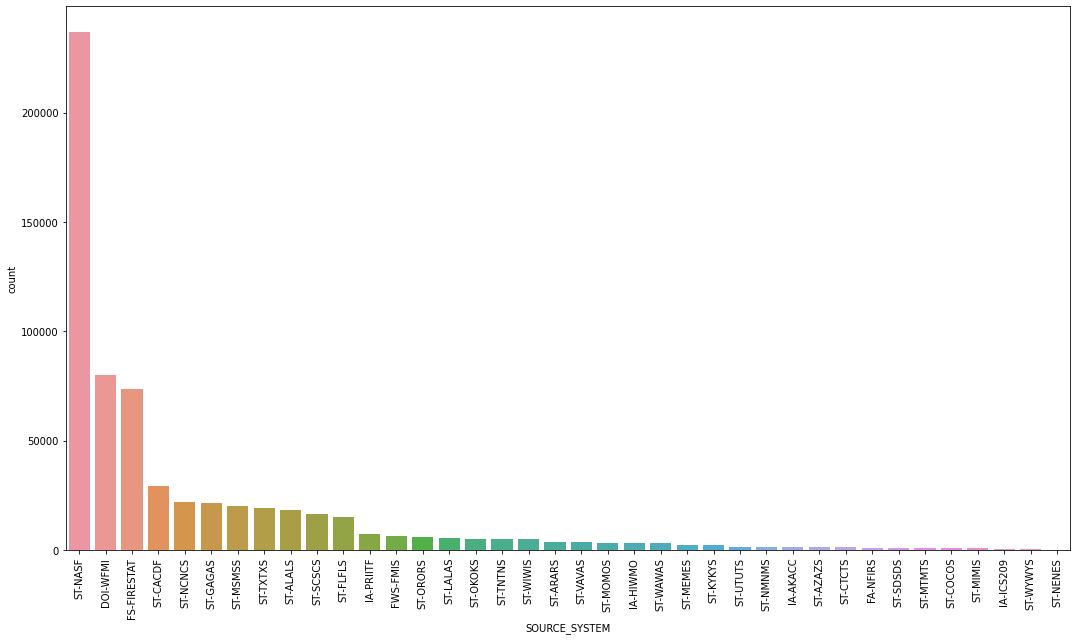

In [16]:
plot_distribution(data['SOURCE_SYSTEM'])

Text(0.5, 1.0, 'Cause by Source System')

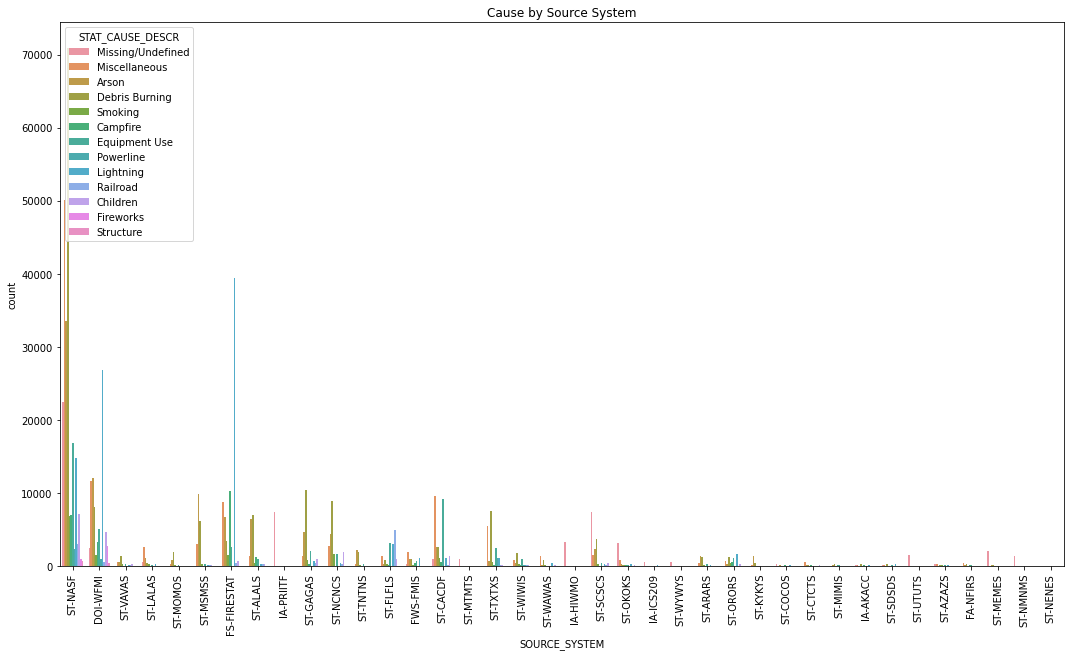

In [17]:
plt.figure(figsize=(18, 10))
plt.xticks(rotation=90)
sns.countplot(data=data, x='SOURCE_SYSTEM',hue='STAT_CAUSE_DESCR').set_title('Cause by Source System')

In [20]:
# l = set(df['SOURCE_SYSTEM'].unique())
# s = {'ST-NASF', 'DOI-WFMI', 'FS-FIRESTAT', 'ST-CACDF', 'ST-NCNCS', 'ST-GAGAS', 'ST-MSMSS', 'ST-TXTXS', 'ST-ALALS', 'ST-SCSCS', 'ST-FLFLS'}
# l - s

titles_to_remove = ['FA-NFIRS',
 'FWS-FMIS',
 'IA-AKACC',
 'IA-HIWMO',
 'IA-ICS209',
 'IA-PRIITF',
 'ST-ARARS',
 'ST-AZAZS',
 'ST-COCOS',
 'ST-CTCTS',
 'ST-KYKYS',
 'ST-LALAS',
 'ST-MEMES',
 'ST-MIMIS',
 'ST-MOMOS',
 'ST-MTMTS',
 'ST-NENES',
 'ST-NMNMS',
 'ST-OKOKS',
 'ST-ORORS',
 'ST-SDSDS',
 'ST-TNTNS',
 'ST-UTUTS',
 'ST-VAVAS',
 'ST-WAWAS',
 'ST-WIWIS',
 'ST-WYWYS']
data["SOURCE_SYSTEM"] = data["SOURCE_SYSTEM"].apply(lambda x:replace_fringe_titles(x, titles_to_remove, 'OTHER'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


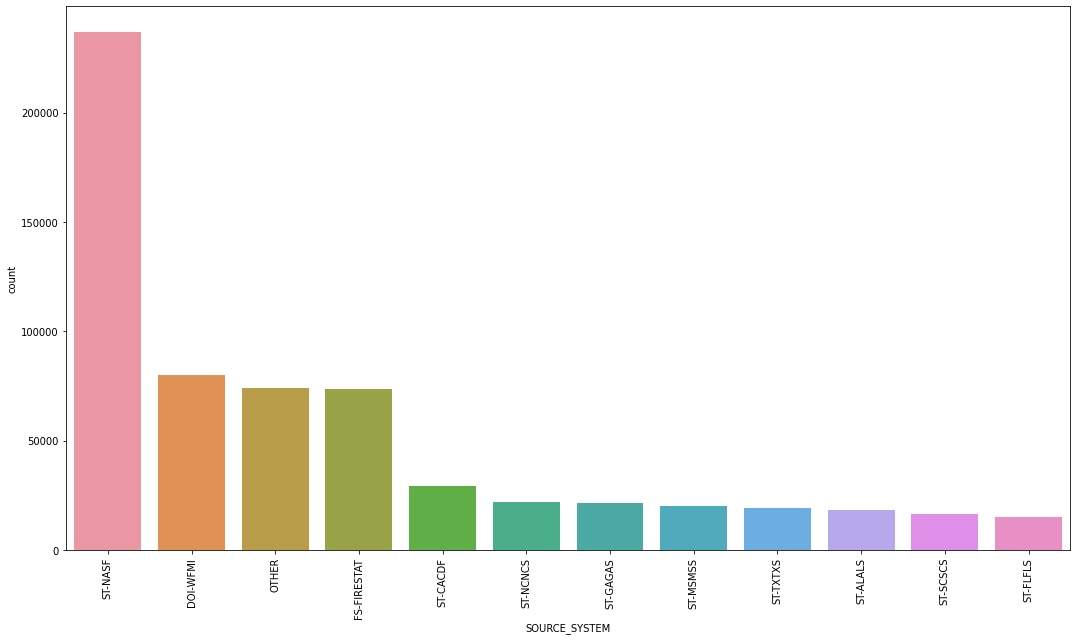

In [21]:
plot_distribution(data['SOURCE_SYSTEM'])

In [22]:
data = pd.get_dummies(data, columns=['SOURCE_SYSTEM'])

## NWCG_REPORTING_AGENCY

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


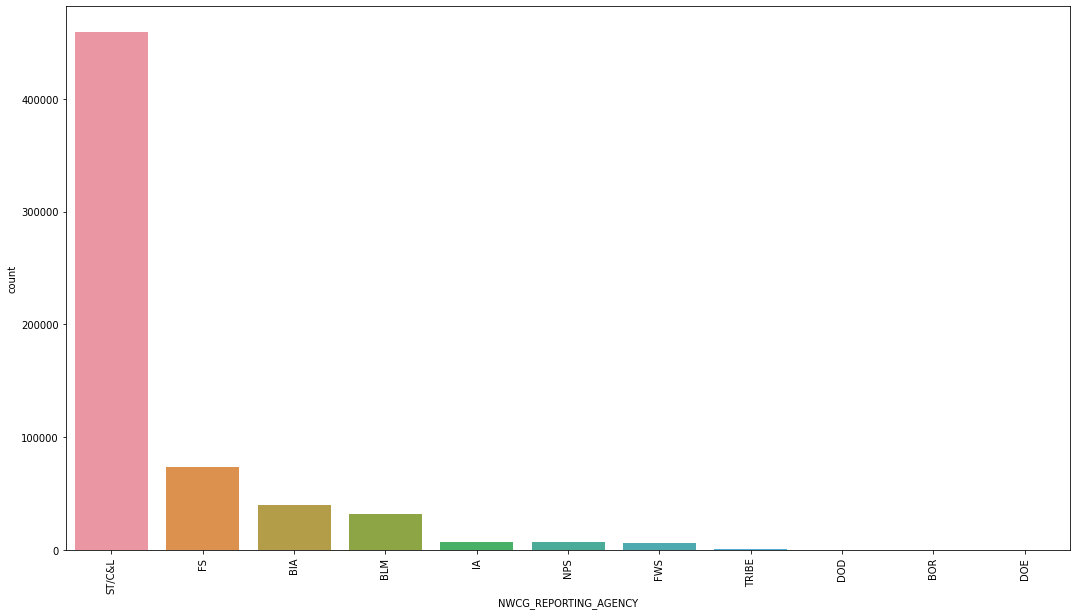

In [23]:
plot_distribution(data['NWCG_REPORTING_AGENCY'])

Text(0.5, 1.0, 'Cause by NWCG Reporting Agency')

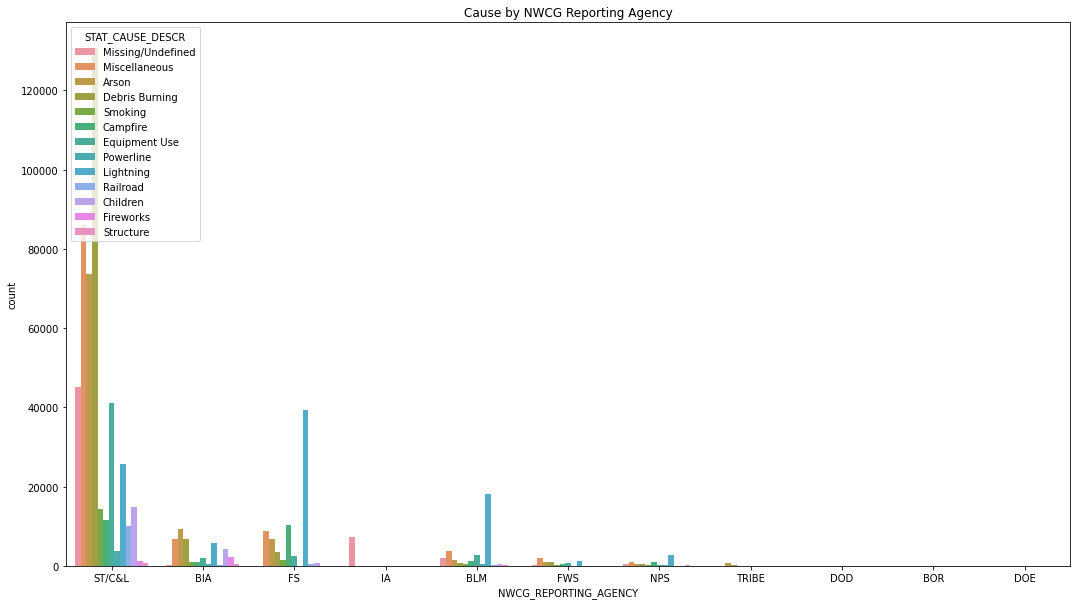

In [24]:
plt.figure(figsize=(18, 10))
sns.countplot(data=data, x='NWCG_REPORTING_AGENCY',hue='STAT_CAUSE_DESCR').set_title('Cause by NWCG Reporting Agency')

In [25]:
titles_to_remove = ["NPS", "FWS", "TRIBE", "DOD", "BOR", "DOE"]

data["NWCG_REPORTING_AGENCY"] = data["NWCG_REPORTING_AGENCY"].apply(lambda x:replace_fringe_titles(x, titles_to_remove, 'OTHER'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


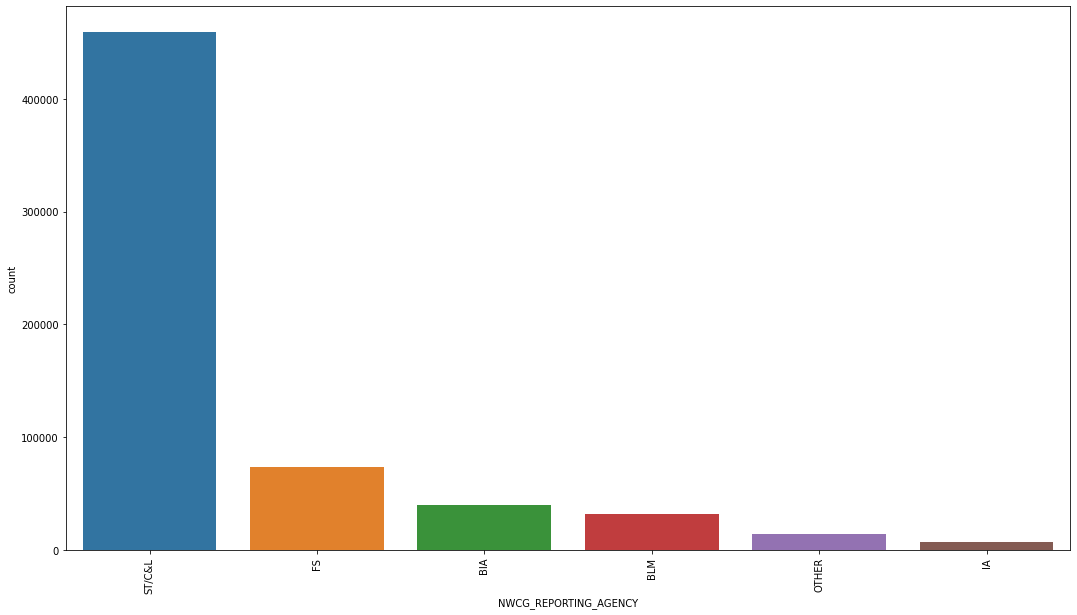

In [26]:
plot_distribution(data['NWCG_REPORTING_AGENCY'])

In [27]:
data = pd.get_dummies(data, columns=['NWCG_REPORTING_AGENCY'])

## Longitude, Latitude

### Check no illigal values

Let's take a look at the `Longitude` and the `Latitude` features: we expect to see that the values of longitude are in the range [-180,180], and latitude is in the range [-90,90].

In [28]:
len(data.loc[data["LONGITUDE"] < -180])

0

In [29]:
len(data.loc[data["LONGITUDE"] > 180])

0

In [30]:
len(data.loc[data["LATITUDE"] < -90])

0

In [31]:
len(data.loc[data["LATITUDE"] > 90])

0

We can see that there are no unusual values when it comes to longitude and latitude.

## OWNER_DESCR

### Plot distribution

This feature is a categorical feature. We can plot its distribution:

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


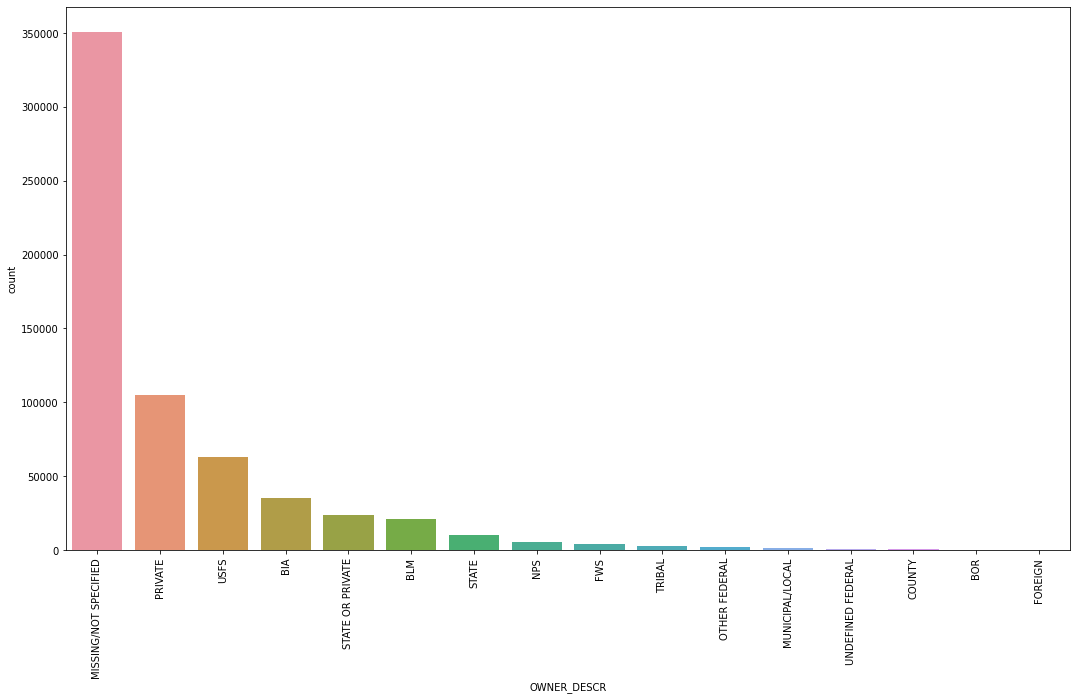

In [32]:
plot_distribution(data["OWNER_DESCR"])

### Binning 
We can see that there are much less rows with the values: `STATE, NPS, FWS, TRIBAL, OTHER FEDERAL, MUNICIPAL/LOCAL, UNDEFINED FEDERAL, COUNTY, BOR, FOREIGN` in the `OWNER_DESCR` column than the other values. That means those categories are quite rare, and we can bin them.

In [33]:
titles_to_remove = ["STATE", "NPS", "FWS", "TRIBAL", "OTHER FEDERAL", "MUNICIPAL/LOCAL", "UNDEFINED FEDERAL", "COUNTY", "BOR", "FOREIGN"]

data["OWNER_DESCR"] = data["OWNER_DESCR"].apply(lambda x:replace_fringe_titles(x, titles_to_remove, 'OTHER'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


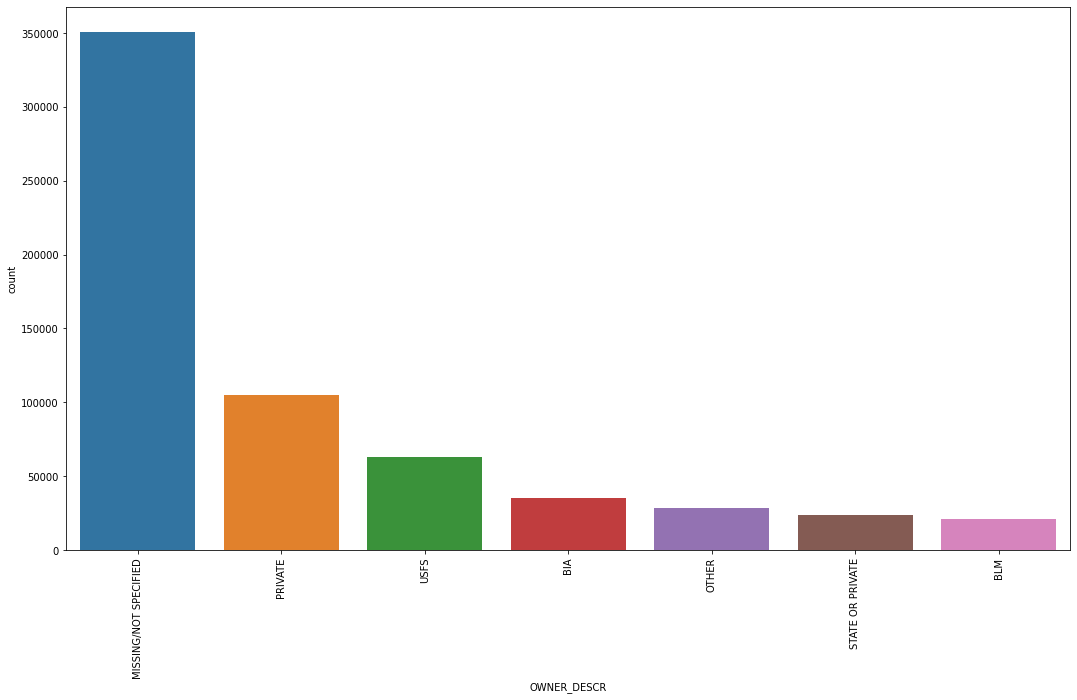

In [34]:
plot_distribution(data["OWNER_DESCR"])

We can now see a much better distribution with no rare categories.

In [35]:
data = pd.get_dummies(data, columns=['OWNER_DESCR'])

In [36]:
data.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE_CLASS,LATITUDE,...,NWCG_REPORTING_AGENCY_IA,NWCG_REPORTING_AGENCY_OTHER,NWCG_REPORTING_AGENCY_ST/C&L,OWNER_DESCR_BIA,OWNER_DESCR_BLM,OWNER_DESCR_MISSING/NOT SPECIFIED,OWNER_DESCR_OTHER,OWNER_DESCR_PRIVATE,OWNER_DESCR_STATE OR PRIVATE,OWNER_DESCR_USFS
0,1998,2451073.5,260,NaN,Missing/Undefined,NaN,NaN,NaN,B,47.600845,...,0,0,1,0,0,1,0,0,0,0
1,2011,2455795.5,234,1645.0,Miscellaneous,2455795.5,234.0,1800.0,A,48.403300,...,0,0,0,0,0,0,0,1,0,0
2,2012,2456066.5,140,1547.0,Miscellaneous,2456066.5,140.0,1630.0,B,40.668460,...,0,0,1,0,0,1,0,0,0,0
3,2002,2452278.5,4,NaN,Miscellaneous,NaN,NaN,NaN,B,39.000000,...,0,0,1,0,0,1,0,0,0,0
4,2002,2452410.5,136,NaN,Arson,NaN,NaN,NaN,B,30.993300,...,0,0,1,0,0,1,0,0,0,0


## FIRE_SIZE_CLASS
`FIRE_SIZE_CLASS` - Code for fire size based on the number of acres within
the final fire perimeter expenditures (A=greater than 0 but less than or
equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres,
E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres). 

### Plot features' distribution

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


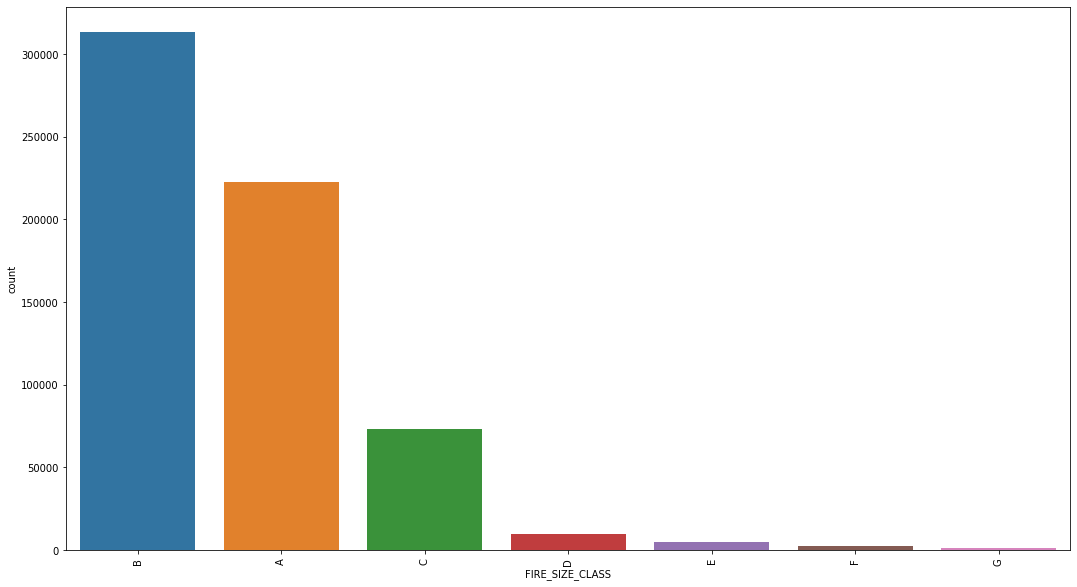

In [37]:
plot_distribution(data['FIRE_SIZE_CLASS'])

We can see fire class size isn't distrbuted uniformly.

More specificly over half of the fires are of size class "B",

around third of them are of size "A",

around tenth of them are of size "C", 

and the rest of the classses appear much less in our data.

In [38]:
unique_values = data["FIRE_SIZE_CLASS"].unique()
unique_values

array(['B', 'A', 'C', 'D', 'F', 'E', 'G'], dtype=object)

### Plot features' distribution with target
Plot target (fire cause) as a function of fire size class

Text(0.5, 1.0, 'Cause by Fire Size Class')

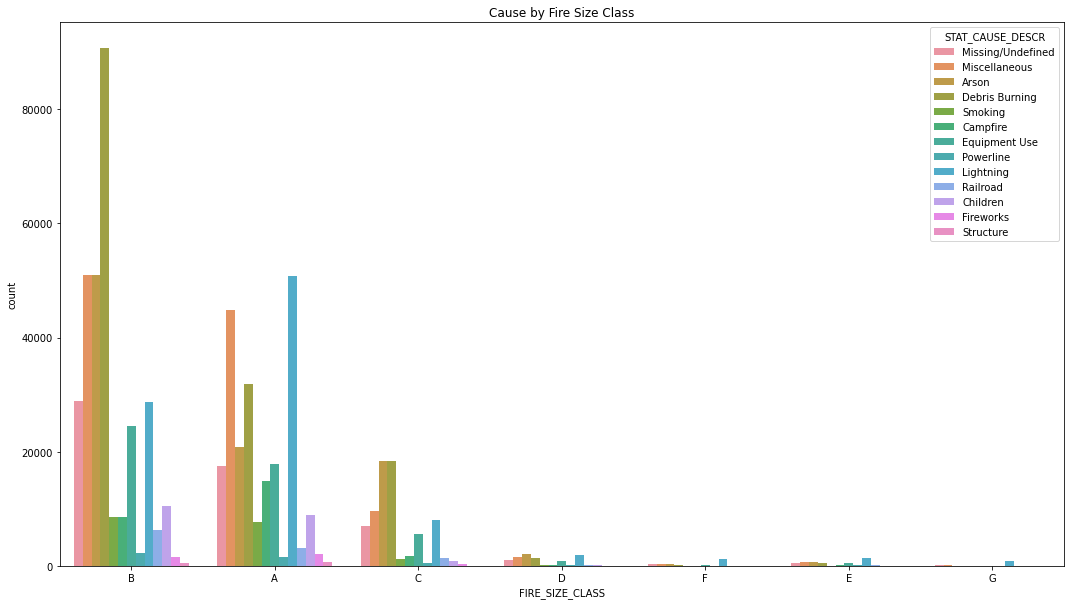

In [39]:
plt.figure(figsize=(18, 10))
sns.countplot(data=data, x='FIRE_SIZE_CLASS',hue='STAT_CAUSE_DESCR').set_title('Cause by Fire Size Class')

We can see that the classes: `D`, `E`, `F`, `G` are rare, and so we can bin those values under `D_AND_LOWER`.

### Binning

The process of binning and then creating dummies will be done after the imputation part since we aggregate over this feature for our imputation.

## Dates and Fire Duration


There are six features in the database describing the fire's,
discovery and containment times: 

`DISCOVERY_DATE`, `DISCOVERY_DOY`, `DISCOVERY_TIME`, `CONT_DATE`, `CONT_DOY`, `CONT_TIME`.

In [49]:
data[['DISCOVERY_DATE', 'DISCOVERY_TIME', 'DISCOVERY_DOY',
      'CONT_DATE', 'CONT_TIME', 'CONT_DOY']].isna().sum()

DISCOVERY_DATE         0
DISCOVERY_TIME    294076
DISCOVERY_DOY          0
CONT_DATE         297088
CONT_TIME         323860
CONT_DOY          297088
dtype: int64

We won't use the `CONT_DOY`, therefore we'll first drop this columns:

In [50]:
data = data.drop(columns=['CONT_DOY'])

Secondly, we'll drop all null values from the four columns:

In [51]:
data_no_null = data.dropna(subset=['CONT_DATE', 'CONT_TIME', 'DISCOVERY_DATE', 'DISCOVERY_TIME'])

In [52]:
df_no_null = data_no_null.copy(deep=True)

### Create full discovery and cont dates and times.
The difference in hour is written as a float in the format `hhmm`. This is problematic, since hours such as 00:04 are converted to 4 as a float. We would like to convert them to a string in the format: `hh:mm`.

In [53]:
def convert_number_to_hhmm(df, col_name):
  # convert to string
  hours_diff_df = df.loc[~df[col_name].isnull()][col_name].astype(int).astype(str)

  # transform into a 4 digit format
  hours_diff_df = hours_diff_df.apply(lambda x: (4-len(x))*"0" + x)
  hours_diff_df = hours_diff_df.apply(lambda x: x[:2] + ':' + x[2:])

  return hours_diff_df

In [54]:
df_no_null["CONT_TIME"] = convert_number_to_hhmm(df_no_null, "CONT_TIME")
df_no_null["DISCOVERY_TIME"] = convert_number_to_hhmm(df_no_null, "DISCOVERY_TIME")

Next step is creating a unified full date and time of day
for discovery and containment of fire.
New dates will be in format: 'yy-mm-dd hh:mm'

First, let's deal with the `CONT_DATE` and `DISCOVERY_DATE` features: we'll convert them to the julian calendar.

In [55]:
df_no_null['CONT_DATE'] = pd.to_datetime(df_no_null['CONT_DATE'], unit='D', origin='julian').astype(str)
df_no_null['DISCOVERY_DATE'] = pd.to_datetime(df_no_null['DISCOVERY_DATE'], unit='D', origin='julian').astype(str)

In [56]:
from datetime import datetime
def unify_to_full_date(data, col_name_date: str, col_name_time: str, 
                       format=''):
  data[col_name_date] = data[col_name_date] + ' ' + data[col_name_time]
  data[col_name_date] = data[col_name_date].apply(lambda x: datetime.strptime(x, format))
  return data

In [57]:
full_date_format = '%Y-%m-%d %H:%M'
df_no_null = unify_to_full_date(df_no_null, 'CONT_DATE', 'CONT_TIME', full_date_format)
df_no_null = unify_to_full_date(df_no_null, 'DISCOVERY_DATE', 'DISCOVERY_TIME', full_date_format)

Compute delta in hours between Cont' and Disc' full times (date + time of day),
for creating duration feature 

### FIRE_DURATION

Now a new feature: FIRE_DURATION : float

will be created according to time delta of:

('CONT_DATE CONT_TIME'  - 'DISCOVERY_DATE DISCOVERY_TIME')

This feature represents the fire duration in hours.

In [58]:
from datetime import timedelta as dt
df_no_null['FIRE_DURATION'] = (df_no_null['CONT_DATE'] - df_no_null['DISCOVERY_DATE']).dt.total_seconds() / 3600.0

We noticed that 37,713 rows have the same cont and discovery date and time. This ofcourse does not make any sence, so we've decided to drop those rows.
(If not dropping we are left with FIRE_DURATION = 0, which logically don't make sense.).

In [59]:
len(np.where(df_no_null['CONT_DATE'] == df_no_null['DISCOVERY_DATE'])[0])

37713

In [60]:
df_no_null = df_no_null.loc[df_no_null['FIRE_DURATION'] != 0]

In [61]:
data["FIRE_DURATION"] = df_no_null["FIRE_DURATION"]

In [62]:
data = data.drop(columns=['DISCOVERY_DATE', 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_TIME'])

## SEASON

### Check no illigal values

In [63]:
data['DISCOVERY_DOY'].unique()

array([260, 234, 140,   4, 136, 109, 324, 123, 293, 210, 135, 144,  78,
        57, 231,  36,  43, 116, 158, 240,  12,  39, 201,  53, 219, 252,
       256,  98, 238,  86, 183, 246, 106, 319, 179, 280,   7, 111, 192,
        58,   3,  92,  40,  90, 267, 220,  62, 296,  64, 348, 278, 275,
       196, 195, 212, 223, 209, 314, 230,  19,  85, 120, 121, 264,  71,
       221, 137, 250, 328, 128, 171,  68, 226, 202, 163,  73, 102, 304,
       138, 361, 279,  47, 284, 203, 251,  55,  50, 180, 249, 327, 174,
       254,  88, 101,  25,  49, 152, 286, 243, 105, 222, 239, 185, 224,
       337, 290,  74, 113, 213, 216,  76, 287, 117, 119, 153, 334, 235,
       274,  70,  17, 167, 214,   5, 206, 241, 261, 188, 132, 353, 255,
        52, 269,   1, 107,  48, 130, 318,  37, 164, 317, 115,  26,  97,
       200, 168,  66,  61,  94,  38,  81, 266, 263,  99,  44, 149, 326,
       360,  51,  29,  42, 227, 103, 245,  89, 139, 181,  67, 133, 268,
       217,  35, 182, 218, 302, 298,  22,  30, 129,  95, 166,  6

In [64]:
len(data['DISCOVERY_DOY'].unique())

366

### Generate SEASON columns

Seasons in the united states:
- Spring - March to May. 60-151
- Summer - June to August. 152-243
- Autumn - September to November.244-334
- Winter - December to February. 335 - 59


In [65]:
def season_generator (row):
   if row['DISCOVERY_DOY'] >= 60 and row['DISCOVERY_DOY'] <= 151:
      return 'SPRING'
   elif row['DISCOVERY_DOY'] >= 152 and row['DISCOVERY_DOY'] <= 243:
      return 'SUMMER'
   elif row['DISCOVERY_DOY'] >= 244 and row['DISCOVERY_DOY'] <= 334:
      return 'AUTOMN'
   else:
    return 'WINTER'

In [66]:
data['SEASON'] = data.apply (lambda row: season_generator(row), axis=1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


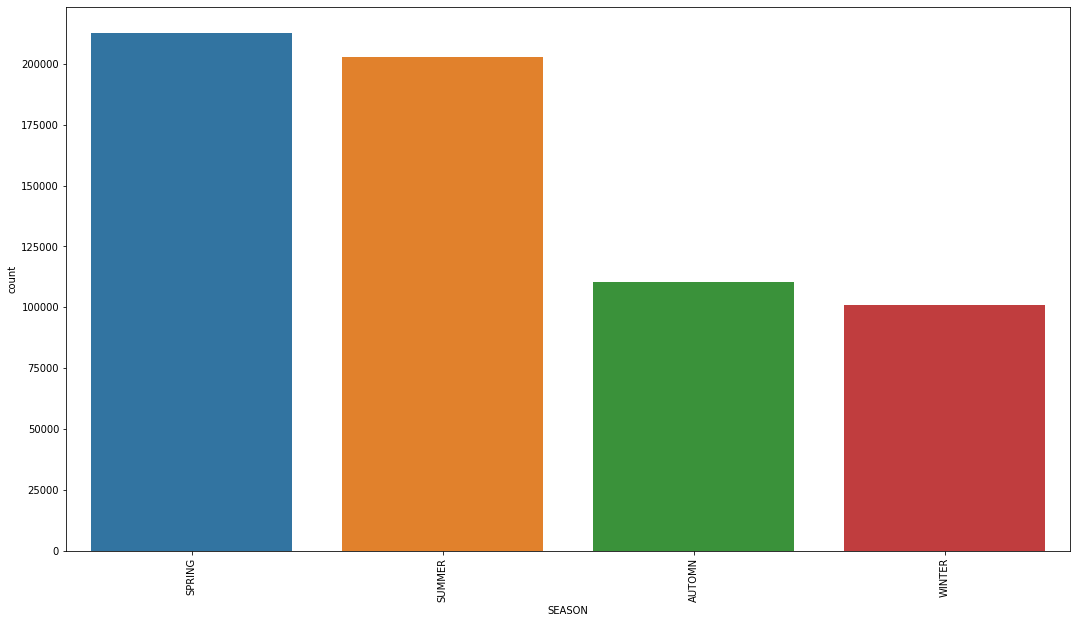

In [67]:
plot_distribution(data['SEASON'])

Text(0.5, 1.0, 'Cause by Season')

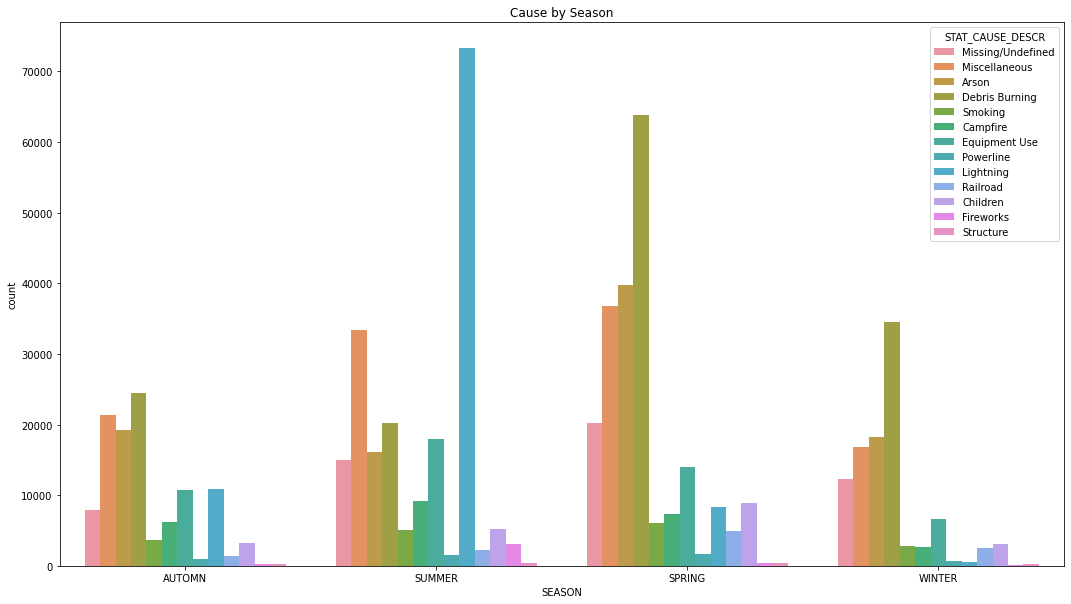

In [68]:
plt.figure(figsize=(18, 10))
sns.countplot(data=data, x='SEASON',hue='STAT_CAUSE_DESCR').set_title('Cause by Season')

In [69]:
data = pd.get_dummies(data, prefix=["DISCOVERY_SEASON"], columns=['SEASON'])

In [70]:
data = data.drop(columns=['DISCOVERY_DOY'])

## Train-Test Split

Before doing any imputation, we'll split the data into train and test sets and impute for both sets seperately to avoid data leakage.

Moreover, we might want to sample the data because hyperparameter optimization and feature importance might take a long time for the full data.

In [71]:
frac = 0.5
data_sample = data.sample(frac=frac)

X = data_sample.drop(columns=target).copy(deep=True)
y = data_sample[target].to_numpy().ravel()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Imputations

### FIRE_DURATION

impute missing "FIRE_DURATION" values by eps 
from avg fire_duration of no_null values with same fire size class.

In [73]:
from math import isnan
def impute_fire_duration(data_grouped_by_fire_size, row):
    
  if not isnan(row.FIRE_DURATION):
    return row

  avg_dur = data_grouped_by_fire_size[row.FIRE_SIZE_CLASS]
  eps = avg_dur / 4
  row.FIRE_DURATION = np.random.uniform(low=avg_dur - eps, high=avg_dur + eps)
  return row

Let's check the distribution of the fire duration feature:

In [74]:
X_train_no_null = X_train.dropna(subset=['FIRE_DURATION'])

In [75]:
X_train_gb_fire_size_avg_dur = X_train_no_null.groupby(["FIRE_SIZE_CLASS"])["FIRE_DURATION"].mean()
X_train[["FIRE_DURATION", "FIRE_SIZE_CLASS"]] = X_train[["FIRE_DURATION", "FIRE_SIZE_CLASS"]]\
.apply(lambda row: impute_fire_duration(X_train_gb_fire_size_avg_dur, row), axis=1)

In [76]:
X_test_no_null = X_test.dropna(subset=['FIRE_DURATION'])

In [77]:
X_test_gb_fire_size_avg_dur = X_test_no_null.groupby(["FIRE_SIZE_CLASS"])["FIRE_DURATION"].mean()
X_test[["FIRE_DURATION", "FIRE_SIZE_CLASS"]] = X_test[["FIRE_DURATION", "FIRE_SIZE_CLASS"]]\
.apply(lambda row: impute_fire_duration(X_test_gb_fire_size_avg_dur, row), axis=1)

#### Binning for FIRE_SIZE_CLASS

In [78]:
titles_to_remove = ['D', 'E', 'F', 'G']
X_train["FIRE_SIZE_CLASS"] = X_train["FIRE_SIZE_CLASS"].apply(lambda x:replace_fringe_titles(x, titles_to_remove, 'D_AND_LOWER'))
X_test["FIRE_SIZE_CLASS"] = X_test["FIRE_SIZE_CLASS"].apply(lambda x:replace_fringe_titles(x, titles_to_remove, 'D_AND_LOWER'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


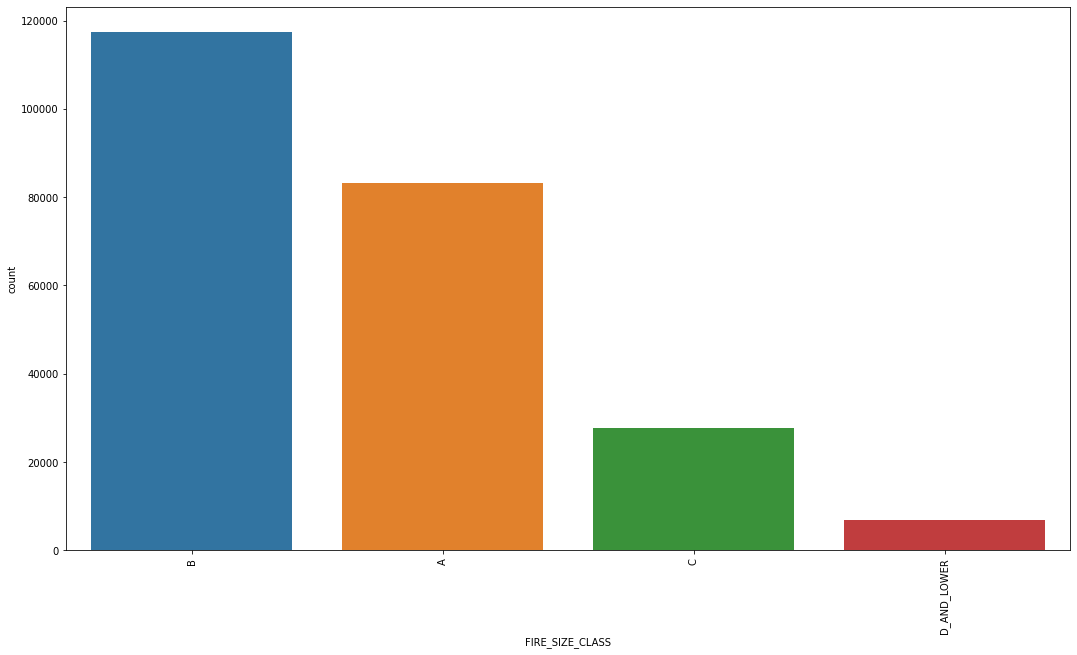

In [79]:
plot_distribution(X_train['FIRE_SIZE_CLASS'])

In [80]:
X_train = pd.get_dummies(X_train, prefix=["FIRE_SIZE_CLASS"], columns=["FIRE_SIZE_CLASS"])
X_test = pd.get_dummies(X_test, prefix=["FIRE_SIZE_CLASS"], columns=["FIRE_SIZE_CLASS"])

# Final Features

In [127]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235058 entries, 25564 to 312068
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   FIRE_YEAR                          235058 non-null  int64  
 1   LATITUDE                           235058 non-null  float64
 2   LONGITUDE                          235058 non-null  float64
 3   SOURCE_SYSTEM_DOI-WFMI             235058 non-null  uint8  
 4   SOURCE_SYSTEM_FS-FIRESTAT          235058 non-null  uint8  
 5   SOURCE_SYSTEM_OTHER                235058 non-null  uint8  
 6   SOURCE_SYSTEM_ST-ALALS             235058 non-null  uint8  
 7   SOURCE_SYSTEM_ST-CACDF             235058 non-null  uint8  
 8   SOURCE_SYSTEM_ST-FLFLS             235058 non-null  uint8  
 9   SOURCE_SYSTEM_ST-GAGAS             235058 non-null  uint8  
 10  SOURCE_SYSTEM_ST-MSMSS             235058 non-null  uint8  
 11  SOURCE_SYSTEM_ST-NASF              

# Baselining



In [81]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.6 MB/s eta 0:00:00


## HistGradientBoostingClassifier

Use F1 weighted score for multiclass classification. 

In [82]:
f1_weighted = make_scorer(f1_score, average='weighted') 

### Most basic HGB model

In [83]:
hgb_model = HistGradientBoostingClassifier(random_state=50,
                                           verbose=2,
                                           loss='categorical_crossentropy').fit(X_train, y_train)
y_hgb_pred = hgb_model.predict(X_test)
print(classification_report(y_test, y_hgb_pred))

Binning 0.063 GB of training data: 1.479 s
Binning 0.007 GB of validation data: 0.170 s
Fitting gradient boosted rounds:
[1/100] 13 trees, 403 leaves (31 on avg), max depth = 14, train loss: 1.91431, val loss: 1.92183, in 9.006s
[2/100] 13 trees, 403 leaves (31 on avg), max depth = 14, train loss: 1.80958, val loss: 1.82026, in 8.435s
[3/100] 13 trees, 403 leaves (31 on avg), max depth = 20, train loss: 1.73649, val loss: 1.74873, in 12.127s
[4/100] 13 trees, 403 leaves (31 on avg), max depth = 15, train loss: 1.67979, val loss: 1.69241, in 0.883s
[5/100] 13 trees, 403 leaves (31 on avg), max depth = 15, train loss: 1.63360, val loss: 1.64655, in 0.895s
[6/100] 13 trees, 403 leaves (31 on avg), max depth = 15, train loss: 1.59493, val loss: 1.60895, in 0.918s
[7/100] 13 trees, 403 leaves (31 on avg), max depth = 16, train loss: 1.56367, val loss: 1.57842, in 0.907s
[8/100] 13 trees, 403 leaves (31 on avg), max depth = 13, train loss: 1.53496, val loss: 1.54951, in 0.930s
[9/100] 13 tre

`TODO`: Explain the classification report's distribution (Explain that it's unbalanced).

### Hyperparameter Optimization


We chose to use Bayesian Optimization for the hyperparameters. Also, we need a way to account for the imbalance in both the train and validation sets due to our imbalanced data. To do so we stratified the target classes, meaning that both sets will have an equal proportion of all classes, using the StratifiedKFold class, and performed cross-validation with this method.

In [85]:
import optuna
sk_folds = StratifiedKFold(n_splits = 5)

def objective(trial):    
    params={}
    params['max_depth'] = trial.suggest_int('max_depth', 10, 25)
    params['max_leaf_nodes'] = trial.suggest_int('max_leaf_nodes', 21, 35)
    params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 20, 30)
    params['l2_regularization'] = trial.suggest_float('l2_regularization', 0, 0.1)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 0.3)

    model = HistGradientBoostingClassifier(random_state=50, **params)
    res = cross_val_score(model, X_train, y_train, scoring=f1_weighted ,cv=sk_folds).mean()
    return res

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=5400)

trial = study.best_trial

print('Best score: {}'.format(trial.value))

[I 2023-02-23 09:48:01,775] A new study created in memory with name: no-name-4b894bbe-0dd5-4748-99ad-da243390cfb3
[I 2023-02-23 09:54:47,235] Trial 0 finished with value: 0.52775882542183 and parameters: {'max_depth': 12, 'max_leaf_nodes': 29, 'min_samples_leaf': 22, 'l2_regularization': 0.010379149183933557, 'learning_rate': 0.10796894294938289}. Best is trial 0 with value: 0.52775882542183.
[I 2023-02-23 09:55:48,769] Trial 1 finished with value: 0.506081607602909 and parameters: {'max_depth': 20, 'max_leaf_nodes': 29, 'min_samples_leaf': 30, 'l2_regularization': 0.05132162945774006, 'learning_rate': 0.25669979433708134}. Best is trial 0 with value: 0.52775882542183.
[I 2023-02-23 09:56:43,836] Trial 2 finished with value: 0.49772384811798576 and parameters: {'max_depth': 17, 'max_leaf_nodes': 22, 'min_samples_leaf': 28, 'l2_regularization': 0.02713444765797809, 'learning_rate': 0.25539849854621444}. Best is trial 0 with value: 0.52775882542183.
[I 2023-02-23 10:03:36,089] Trial 3 fi

Best score: 0.5312489969381302


In [86]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [87]:
# This can be used to train the final model. Passed through using kwargs into the model
best_params = {}
print('Finding study best parameters')
best_params['max_depth'] = int(study.best_params['max_depth'])
best_params['max_leaf_nodes'] = int(study.best_params['max_leaf_nodes'])
best_params['min_samples_leaf'] = int(study.best_params['min_samples_leaf'])
best_params['l2_regularization'] = float(study.best_params['l2_regularization'])
best_params['learning_rate'] = float(study.best_params['learning_rate'])

print(f'Best Hyper-parameters are: {best_params}')

Finding study best parameters
Best Hyper-parameters are: {'max_depth': 13, 'max_leaf_nodes': 25, 'min_samples_leaf': 26, 'l2_regularization': 0.09665996246059405, 'learning_rate': 0.17822917024415935}


In [119]:
hgb = HistGradientBoostingClassifier(random_state=50,
                                     verbose=2,
                                     loss='categorical_crossentropy',
                                     **best_params).fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)
print(classification_report(y_test, hgb_pred))

Binning 0.063 GB of training data: 0.702 s
Binning 0.007 GB of validation data: 0.015 s
Fitting gradient boosted rounds:
[1/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.82657, val loss: 1.83087, in 0.836s
[2/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 2.21536, val loss: 2.38723, in 0.824s
[3/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 2.01145, val loss: 2.05045, in 0.813s
[4/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.90305, val loss: 1.94056, in 0.838s
[5/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.74808, val loss: 1.81314, in 0.844s
[6/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.71123, val loss: 1.79178, in 0.889s
[7/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.66424, val loss: 1.74122, in 0.824s
[8/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.63511, val loss: 1.70851, in 3.577s
[9/100] 13 tree

### Feature Importance

For feature importance we chose the permutation method.

In [89]:
result = permutation_importance(hgb, X_train, y_train, n_repeats=10, random_state=1)

In [90]:
feature_importances = sorted(list(zip(X_train.columns, result['importances_mean'])), key=lambda x: -x[1])

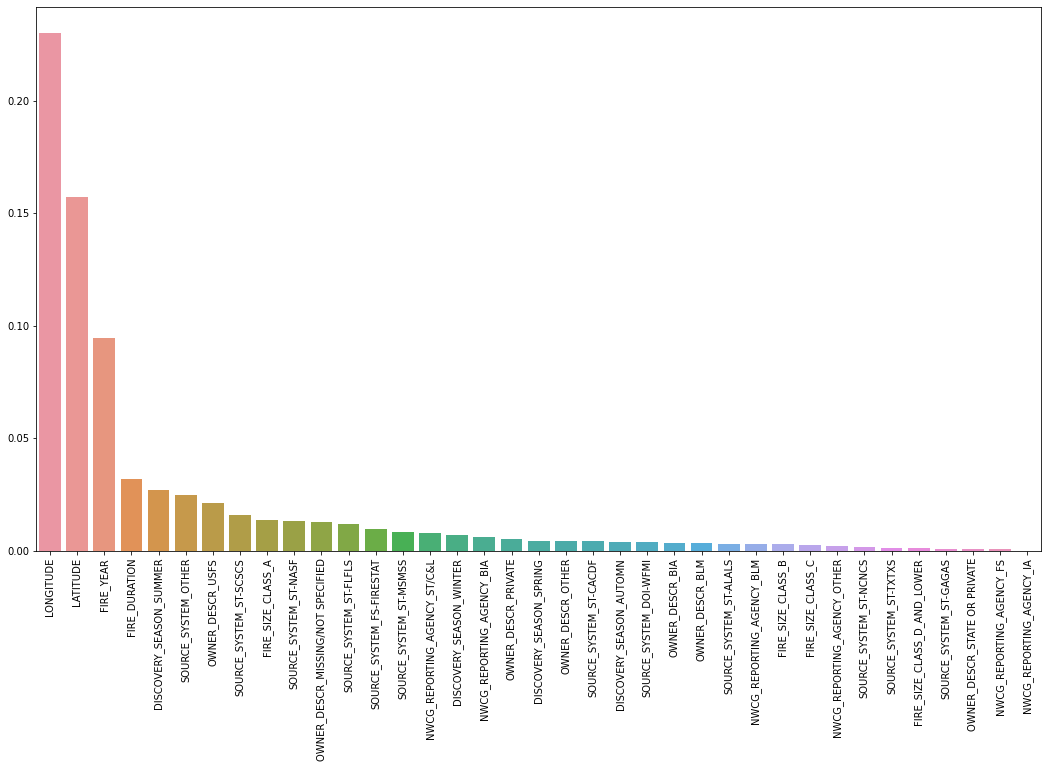

In [91]:
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])

plt.figure(figsize=(18, 10))
plt.xticks(rotation = 90)
sns.barplot(x=columns, y=importances)

We'll now fit the model with top 15 and 10 features to see if the model's performance gets better.

In [120]:
top_30 = columns[:30]

In [121]:
X_train_30, X_test_30 = X_train[top_30], X_test[top_30]

In [122]:
hgb = HistGradientBoostingClassifier(random_state=50,
                                     verbose=2,
                                     loss='categorical_crossentropy',
                                     **best_params).fit(X_train_30, y_train)
hgb_pred = hgb.predict(X_test_30)
print(classification_report(y_test, hgb_pred))

Binning 0.051 GB of training data: 0.628 s
Binning 0.006 GB of validation data: 0.012 s
Fitting gradient boosted rounds:
[1/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.82646, val loss: 1.83138, in 3.873s
[2/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 2.21528, val loss: 2.38763, in 0.739s
[3/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.94648, val loss: 1.93838, in 0.736s
[4/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.86863, val loss: 1.84443, in 0.746s
[5/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.80504, val loss: 1.78408, in 0.739s
[6/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.76130, val loss: 1.74407, in 0.738s
[7/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.73323, val loss: 1.71594, in 0.749s
[8/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.70514, val loss: 1.69321, in 0.731s
[9/100] 13 tree

In [116]:
top_20 = columns[:20]

In [117]:
X_train_20, X_test_20 = X_train[top_20], X_test[top_20]

In [118]:
hgb = HistGradientBoostingClassifier(random_state=50,
                                     verbose=2,
                                     loss='categorical_crossentropy',
                                     **best_params).fit(X_train_20, y_train)
hgb_pred = hgb.predict(X_test_20)
print(classification_report(y_test, hgb_pred))

Binning 0.034 GB of training data: 0.744 s
Binning 0.004 GB of validation data: 0.017 s
Fitting gradient boosted rounds:
[1/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.83040, val loss: 1.83460, in 2.167s
[2/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 2.02671, val loss: 2.14391, in 1.422s
[3/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.88071, val loss: 1.97698, in 2.869s
[4/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.74797, val loss: 1.82224, in 0.577s
[5/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.66779, val loss: 1.72435, in 0.607s
[6/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.61465, val loss: 1.66991, in 0.592s
[7/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.55608, val loss: 1.57326, in 0.605s
[8/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.53184, val loss: 1.54112, in 0.630s
[9/100] 13 tree

In [104]:
top_15 = columns[:15]

In [110]:
X_train_15, X_test_15 = X_train[top_15], X_test[top_15]

In [111]:
hgb = HistGradientBoostingClassifier(random_state=50,
                                     verbose=2,
                                     loss='categorical_crossentropy',
                                     **best_params).fit(X_train_15, y_train)
hgb_pred = hgb.predict(X_test_15)
print(classification_report(y_test, hgb_pred))

Binning 0.025 GB of training data: 0.589 s
Binning 0.003 GB of validation data: 0.264 s
Fitting gradient boosted rounds:
[1/100] 13 trees, 325 leaves (25 on avg), max depth = 11, train loss: 1.83293, val loss: 1.83667, in 0.983s
[2/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.75393, val loss: 1.76280, in 0.485s
[3/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.66219, val loss: 1.65888, in 0.501s
[4/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.60567, val loss: 1.60282, in 0.512s
[5/100] 13 trees, 325 leaves (25 on avg), max depth = 12, train loss: 1.56753, val loss: 1.56903, in 0.540s
[6/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.53164, val loss: 1.53252, in 0.482s
[7/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.50750, val loss: 1.50914, in 0.519s
[8/100] 13 trees, 325 leaves (25 on avg), max depth = 13, train loss: 1.48515, val loss: 1.48518, in 0.495s
[9/100] 13 tree

* We can see that when we use the first 30 and 20 features, the weighted average f1-score does not change, but the weighted average of the precision is slightly greater (from 0.53 to 0.54) while the weighted average recall stayed the same. This does not necessarily mean the model is better - a better model will increase the recall and decrease the precision. Here, the precision increased but there might have been a change in recall (probably decreased) but we don't see it because the number only shows 2 digits after the decimal point. Since we can't be sure, and the difference is very small, we don't consider this model to be better.

* When we used the 10 best features, the weighted average f1-score got smaller (from 0.53 to 0.52), hence it is not a better model.

# Conclusion

Our final model is the Histogram-based Gradient Boosting Classification Tree, with the default parameters: 

`random_state`: 50

`verbose`: 2

`loss`: 'categorical_crossentropy'

and the optimized parameters:

`max_depth`: 13

`max_leaf_nodes`: 25

`min_samples_leaf`: 26

`l2_regularization`: 0.09665996246059405

`learning_rate`: 0.17822917024415935

(The optimized parameters might vary according to the sample of the data and the split for train and test sets).

The highest weighted average f1-score we achieved: `0.53`.
